# rdf_demo

This notebook demonstrates the rdf data generated by a HoboReader instance.

## Create HoboReader instance and read in csv file

In [1]:
from hoboreader import HoboReader
h=HoboReader('sample_hobo_data.csv')

## Create rdf data

In [2]:
g=h.get_rdf(my_sensor_id=r'http://www.example.org/MyHobo',
            my_sensor_model='Hobo Pendant',
            my_sensor_manufacturer='Onset',
            my_feature_of_interest_id=r'http://www.example.org/MyLivingRoom')

## Query graph

### Number of triples

In [3]:
len(g)

26033

### What predicates are used?

In [4]:
qres = g.query(
"""
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?p (COUNT(?p) AS ?count)
    WHERE 
    {
        ?s ?p ?o .
    }
    GROUP BY ?p
"""
)
[[str(x) for x in row] for row in qres]

[['http://www.w3.org/ns/sosa/hasFeatureOfInterest', '2003'],
 ['http://www.w3.org/ns/sosa/isFeatureOfInterestOf', '2003'],
 ['http://www.w3.org/ns/sosa/hasResult', '1993'],
 ['http://www.w3.org/ns/sosa/observedProperty', '2003'],
 ['http://www.w3.org/2006/time#inXSDDateTimeStamp', '2000'],
 ['http://www.w3.org/1999/02/22-rdf-syntax-ns#type', '6020'],
 ['http://www.w3.org/ns/sosa/madeBySensor', '1993'],
 ['http://www.w3.org/ns/sosa/madeObservation', '1993'],
 ['http://qudt.org/schema/qudt/unit', '1993'],
 ['http://qudt.org/schema/qudt/numericValue', '1993'],
 ['http://www.w3.org/ns/sosa/resultTime', '2000'],
 ['http://www.w3.org/ns/sosa/hasSimpleResult', '10'],
 ['http://www.w3.org/ns/ssn/isPropertyOf', '9'],
 ['http://qudt.org/schema/qudt/isQuantityKindOf', '1'],
 ['http://www.w3.org/ns/ssn/hasProperty', '9'],
 ['http://www.w3.org/2000/01/rdf-schema#label', '9'],
 ['http://qudt.org/schema/qudt/hasQuantityKind', '1']]

### What classes are used?

In [5]:
qres = g.query(
"""
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?o (COUNT(?o) AS ?count)
    WHERE 
    {
        ?s a ?o .
    }
    GROUP BY ?o
"""
)
[[str(x) for x in row] for row in qres]

[['http://qudt.org/schema/qudt/QuantityValue', '1993'],
 ['http://www.w3.org/2006/time#Instant', '2000'],
 ['http://www.w3.org/ns/sosa/Observation', '2003'],
 ['http://www.w3.org/ns/ssn/System', '1'],
 ['http://www.purl.org/berg/ontology/objects#PhysicalObject', '2'],
 ['http://www.w3.org/ns/sosa/ObservableProperty', '9'],
 ['http://www.w3.org/ns/ssn/Property', '9'],
 ['http://www.w3.org/ns/sosa/Sensor', '1'],
 ['http://www.w3.org/ns/sosa/FeatureOfInterest', '2']]

### Get sensor serial number

In [6]:
q="""
SELECT ?result 
WHERE 
    { 
        ?sensor a sosa:Sensor . 
        ?property rdfs:label "Serial number" .
        ?observation sosa:hasFeatureOfInterest ?sensor ;
            sosa:observedProperty ?property ;
            sosa:hasSimpleResult ?result .
    }
"""
result=list(g.query(q))
sn=result[0][0]
sn

rdflib.term.Literal('10469238')

### Get sensor uri

In [7]:
q="""
SELECT * 
WHERE 
    { 
        ?s a sosa:Sensor . 
        
    }
"""
sensor_uri=list(g.query(q))[0][0]
sensor_uri

rdflib.term.URIRef('http://www.example.org/MyHobo')

### Get property labels

In [8]:
q="""
SELECT ?label 
WHERE 
    { 
        ?property a ssn:Property . 
        ?property rdfs:label ?label
    }
"""
property_labels=list(g.query(q))
property_labels

[(rdflib.term.Literal('Serial number')),
 (rdflib.term.Literal('Model')),
 (rdflib.term.Literal('Manufacturer')),
 (rdflib.term.Literal('Coupler Attached')),
 (rdflib.term.Literal('Stopped')),
 (rdflib.term.Literal('Coupler Detached')),
 (rdflib.term.Literal('Temp')),
 (rdflib.term.Literal('Host Connected')),
 (rdflib.term.Literal('End Of File'))]

### Get temperature data

In [9]:
from datetime import datetime
q="""
SELECT ?datetime ?value ?unit 
WHERE
    {
        ?property rdfs:label 'Temp' . 
        ?observation sosa:observedProperty ?property ;
            sosa:hasResult ?result ;
            sosa:resultTime ?time .
        ?time time:inXSDDateTimeStamp ?datetime .
        ?result qudt:numericValue ?value ;
            qudt:unit ?unit .
    }
ORDER BY ?datetime
"""
result=g.query(q)
vars=[str(x) for x in result.vars]
temp_data=[(datetime.fromisoformat(str(x[0])),x[1].value,x[2]) for x in result]
temp_data[:2]

[(datetime.datetime(2019, 10, 10, 11, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
  72.199,
  rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_F')),
 (datetime.datetime(2019, 10, 10, 11, 5, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
  72.545,
  rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_F'))]

In [10]:
import pandas as pd
df=pd.DataFrame(columns=vars,data=temp_data)
df=df.set_index('datetime')
df.head()

,value,unit
datetime,,
2019-10-10 11:00:00+01:00,72.199,http://qudt.org/vocab/unit/DEG_F
2019-10-10 11:05:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F
2019-10-10 11:10:00+01:00,72.372,http://qudt.org/vocab/unit/DEG_F
2019-10-10 11:15:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F
2019-10-10 11:20:00+01:00,72.545,http://qudt.org/vocab/unit/DEG_F


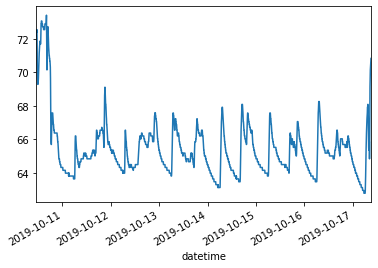

In [11]:
%matplotlib inline
df['value'].plot()